# Import packages

In [7]:
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import ot
import time
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

from utils import *

In [27]:
import sys
sys.path.append("../")

from lib.gromov import gromov_wasserstein, cost_matrix_d, tensor_dot_param, tensor_dot_func, gwgrad_partial1, partial_gromov_wasserstein, partial_gromov_ver1
from lib.linear_gromov import GW_dist,MPGW_dist, PGW_dist_with_penalty

In [87]:
import torch
from unbalancedgw.vanilla_ugw_solver import exp_ugw_sinkhorn
from unbalancedgw._vanilla_utils import ugw_cost

# Load Shapes

In [19]:
posns = np.load("./data/dithPos.dat",allow_pickle=True)
n_points = 50
heights = [np.ones(n_points) / n_points for i in range(len(posns))]

sample_shapes = False

In [20]:
numItem = 20
classes = np.arange(4)
N = len(classes)*20

In [21]:
posns_sampled = []

for i in range(posns.shape[0]):
    pts_to_sample = random.randint(40, 50)
    posns_sampled.append(posns[i, random.sample(range(50), pts_to_sample), :])

# Visualize Classes

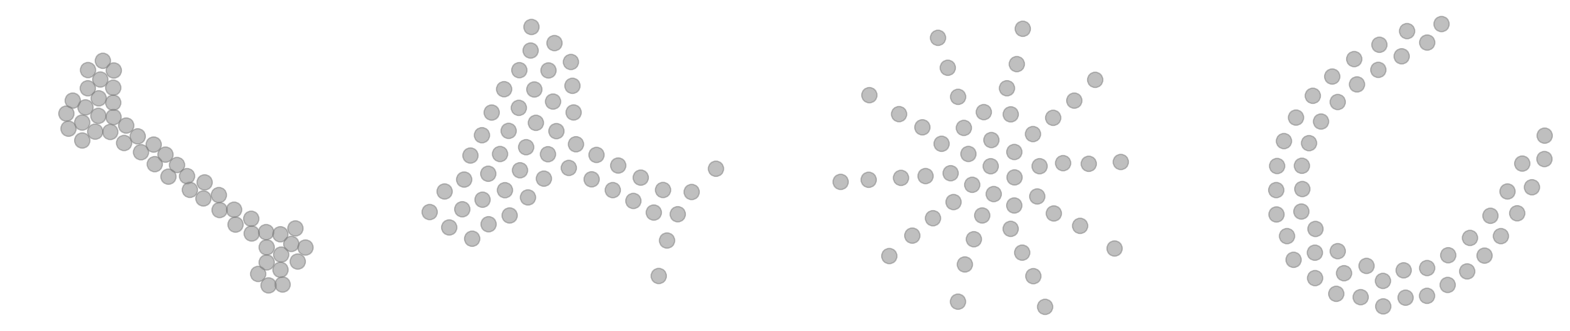

In [22]:
ex_posns = [posns[4], posns[35], posns[45], posns[60]]
ex_heights = [heights[4], heights[35], heights[45], heights[60]]
scatter_atomic(ex_posns, ex_heights, n_plots_per_col=4, xmarkers=False, axis_off=True, margin_fac=0.05)

# GW distances

In [23]:
N = 80
M0s = []
for i in range(80):
    M = ot.dist(posns[i], posns[i], metric="euclidean")
    # posns[i] /= np.max(M)
    # M0s.append(M/np.max(M))
    M0s.append(M)

In [24]:
st = time.time()        
gw0 = np.zeros((N,N))
for i in range(N):
    M1 = M0s[i]
    height1 = heights[i]
    for j in range(i+1, N):
        M2 = M0s[j]
        height2 = heights[j]
        gw0[i, j] = ot.gromov.gromov_wasserstein2(M1, M2, height1, height2, 'square_loss')
gw0 = np.sqrt(gw0)
gw0 += gw0.T
et = time.time()
print("GW computation: " + str(np.round(et-st,2)) + "s")

GW computation: 6.55s


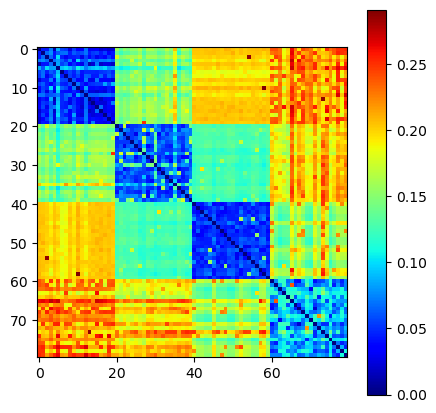

In [25]:
plt.figure(figsize=(5,5))
plt.imshow(gw0, cmap='jet')
plt.colorbar()
plt.show()

# Yikun GW Implementation 

In [30]:
posns = np.load("./data/dithPos.dat",allow_pickle=True)

N = 80
Ms = []
for i in range(80):
    M = cost_matrix_d(posns[i], posns[i])
    Ms.append(np.sqrt(M))

In [31]:
st = time.time()        
gw = np.zeros((N,N))
for i in range(N):
    M1 = Ms[i]
    height1 = heights[i]
    for j in range(i+1, N):
        M2 = Ms[j]
        height2 = heights[j]
        gamma = gromov_wasserstein(M1, M2, height1, height2, G0=None,thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
        gw[i, j] = GW_dist(M1, M2, gamma)
gw = np.sqrt(gw)
gw += gw.T
et = time.time()
print("GW computation: " + str(np.round(et-st,2)) + "s")

GW computation: 9.18s


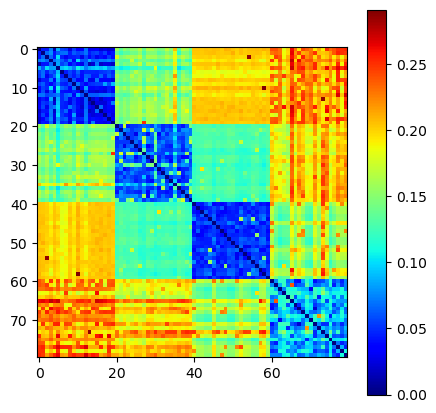

In [32]:
plt.figure(figsize=(5,5))
plt.imshow(gw, cmap='jet')
plt.colorbar()
plt.show()

In [33]:
np.allclose(gw, gw0, rtol=1e-8)

True

# Bounded PGW Distance

In [38]:
posns = np.load("./data/dithPos.dat",allow_pickle=True)

N = 80
Ms = []
for i in range(80):
    M = cost_matrix_d(posns[i], posns[i])
    Ms.append(np.sqrt(M))

st = time.time()        
pgw = np.zeros((N,N))
for i in range(N):
    M1 = Ms[i]
    height1 = heights[i]
    for j in range(i+1, N):
        M2 = Ms[j]
        height2 = heights[j]

        Lambda= 10**10 #1/2*(M1.max()**2+M2.max()**2)
        gamma = partial_gromov_ver1(M1, M2, height1, height2, G0=None, Lambda=Lambda, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
        pgw_trans,pgw_penalty=PGW_dist_with_penalty(M1,M2,gamma, height1, height2, Lambda)
        pgw[i, j]=pgw_trans+pgw_penalty 

pgw = np.sqrt(pgw)
pgw += pgw.T
et = time.time()
print("PGW computation: " + str(np.round(et-st,2)) + "s")

PGW computation: 8.38s


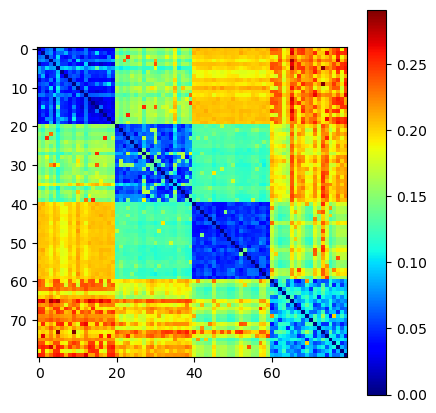

In [39]:
plt.figure(figsize=(5,5))
plt.imshow(pgw, cmap='jet')
plt.colorbar()
plt.show()

In [40]:
np.allclose(pgw, gw0, rtol=1e-8)

False

# Bounded PGW with Subsampling 

In [56]:
from collections import defaultdict
M = defaultdict(dict)
LAMBDA_MAX = 0

for i in range(N):
    for j in range(N):
        shape_i = posns[i]
        shape_j = posns[j]
        M1 = np.sqrt(cost_matrix_d(shape_i, shape_i))
        M2 = np.sqrt(cost_matrix_d(shape_j, shape_j))

        M[i][j] = M1
        M[j][i] = M2
        
        LAMBDA_MAX = max(LAMBDA_MAX, max(M1.max()**2, M2.max()**2))

In [62]:
posns = posns_sampled

N = 80

st = time.time()        
pgw = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        shape_i = posns[i]
        shape_j = posns[j]
        M1 = M[i][j]
        M2 = M[j][i]

        alpha = 1/min(shape_i.shape[0], shape_j.shape[0])
        height1 = np.ones(shape_i.shape[0]) * alpha
        height2 = np.ones(shape_j.shape[0]) * alpha

        Lambda = 1/5 * LAMBDA_MAX
        
        gamma = partial_gromov_ver1(M1, M2, height1, height2, G0=None, Lambda=Lambda, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
        pgw_trans,pgw_penalty=PGW_dist_with_penalty(M1,M2,gamma, height1, height2, Lambda)
        pgw[i, j]=pgw_trans+pgw_penalty 

pgw = np.sqrt(pgw)
et = time.time()
print("PGW computation: " + str(np.round(et-st,2)) + "s")

PGW computation: 16.23s


/tmp/ipykernel_807916/245945154.py:24: RuntimeWarning: invalid value encountered in sqrt
  pgw = np.sqrt(pgw)


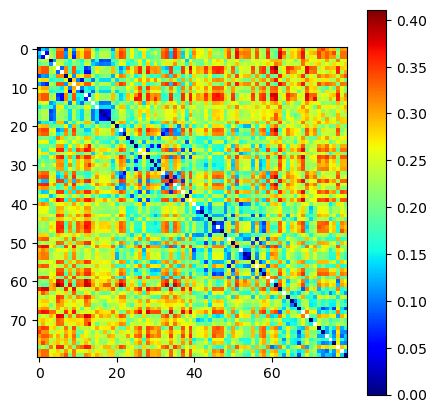

In [63]:
plt.figure(figsize=(5,5))
plt.imshow(pgw, cmap='jet')
plt.colorbar()
plt.show()

# Mass Constrained PGW

In [69]:
posns = posns_sampled

N = 80
pts_to_sample = 40

st = time.time()        
mpgw = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        shape_i = posns[i]
        shape_j = posns[j]
        M1 = np.sqrt(cost_matrix_d(shape_i, shape_i))
        M2 = np.sqrt(cost_matrix_d(shape_j, shape_j))

        alpha = 1/min(shape_i.shape[0], shape_j.shape[0])
        height1 = np.ones(shape_i.shape[0]) * alpha
        height2 = np.ones(shape_j.shape[0]) * alpha

        mass = 1.0 - 1e-10
        gamma = partial_gromov_wasserstein(M1, M2, height1, height2, G0=None, m=mass, thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
        mpgw[i, j]=MPGW_dist(M1,M2,gamma)

mpgw[mpgw < 0] = 0
mpgw = np.sqrt(mpgw)
mpgw += mpgw.T
et = time.time()
print("MPGW computation: " + str(np.round(et-st,2)) + "s")

MPGW computation: 21.19s


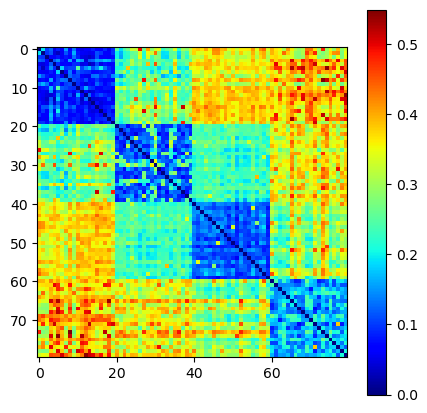

In [72]:
plt.figure(figsize=(5,5))
plt.imshow(mpgw, cmap='jet')
plt.colorbar()
plt.show()

# Unbalanced GW

In [96]:
posns = posns_sampled

N = 80
pts_to_sample = 40

st = time.time()        
ugw = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        shape_i = posns[i]
        shape_j = posns[j]
        M1 = np.sqrt(cost_matrix_d(shape_i, shape_i))
        M2 = np.sqrt(cost_matrix_d(shape_j, shape_j))

        M1 = torch.from_numpy(M1)
        M2 = torch.from_numpy(M2)

        alpha = 1/min(shape_i.shape[0], shape_j.shape[0])
        height1 = np.ones(shape_i.shape[0]) * alpha
        height2 = np.ones(shape_j.shape[0]) * alpha

        height1 = torch.from_numpy(height1)
        height2 = torch.from_numpy(height2)

        eps = 1.0
        rho = rho2 = 1.0

        pi, gamma = exp_ugw_sinkhorn(height1, M1, height2, M2, init=None, eps=eps,
                             rho=rho, rho2=rho2,
                             nits_plan=1000, tol_plan=1e-5,
                             nits_sinkhorn=1000, tol_sinkhorn=1e-5,
                             two_outputs=True)
        cost = ugw_cost(pi, gamma, height1, M1, height2, M2, eps=eps, rho=rho, rho2=rho2)
        ugw[i, j] = cost

ugw[ugw < 0] = 0
ugw = np.sqrt(ugw)
ugw += ugw.T
et = time.time()
print("ugw computation: " + str(np.round(et-st,2)) + "s")

ugw computation: 17.32s


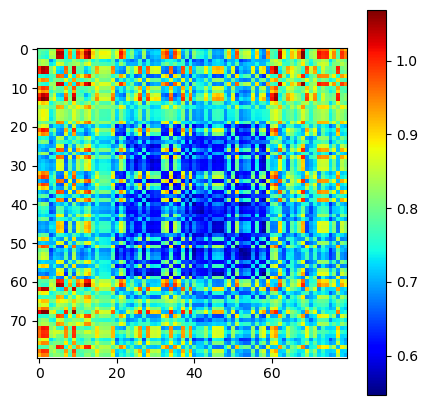

In [97]:
plt.figure(figsize=(5,5))
plt.imshow(ugw, cmap='jet')
plt.colorbar()
plt.show()

# Plot

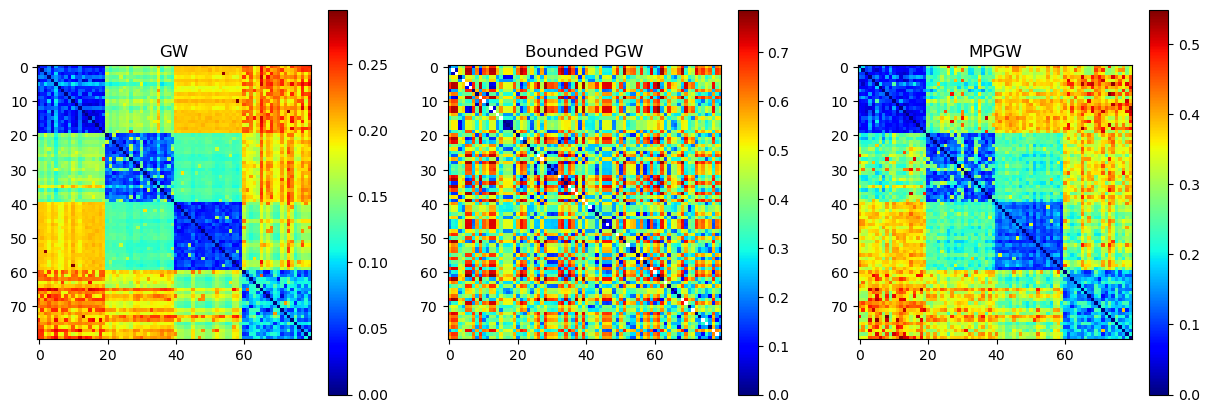

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

img = axs[0].imshow(gw, cmap='jet')
fig.colorbar(img, ax=axs[0])
axs[0].set_title("GW")
img = axs[1].imshow(pgw, cmap='jet')
fig.colorbar(img, ax=axs[1])
axs[1].set_title("Bounded PGW")
img = axs[2].imshow(mpgw, cmap='jet')
fig.colorbar(img, ax=axs[2])
axs[2].set_title("MPGW")

plt.show()

# Reference

In [41]:
idx_bary = [c*numItem for c in range(len(classes))] #indices of shapes for barycenter computation
n_bary = len(idx_bary)
k_bary = 50
    
st = time.time()   
height_ref = ot.unif(k_bary)
M_ref = ot.gromov.gromov_barycenters(k_bary, Cs = np.array(Ms)[idx_bary],
                                           ps = np.array(heights)[idx_bary], p = height_ref, lambdas = ot.unif(n_bary), loss_fun='square_loss',
                                           max_iter=400, tol=1e-12,random_state=2746,log=False)
et = time.time()

print("Barycenter computation: " + str(np.round(et-st,2)) + "s")

Barycenter computation: 3.09s


/home/baly/miniconda3/envs/opt/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


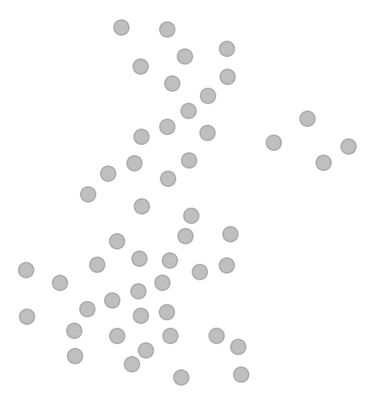

In [36]:
#embedding and plot
mds = MDS(n_components=2, metric=True, dissimilarity='precomputed',random_state=0)
embedding = mds.fit_transform(M_ref)

scatter_atomic(embedding, height_ref, n_plots_per_col=1, xmarkers=False, axis_off=True, margin_fac=0.05)

# LGW distances

In [66]:
lgw0,t = lgw_procedure(M_ref,height_ref,posns,Ms,heights,mode="euclidean")
print("LGW computation: " + str(np.round(t,2)) + "s")

LGW computation: 0.41s


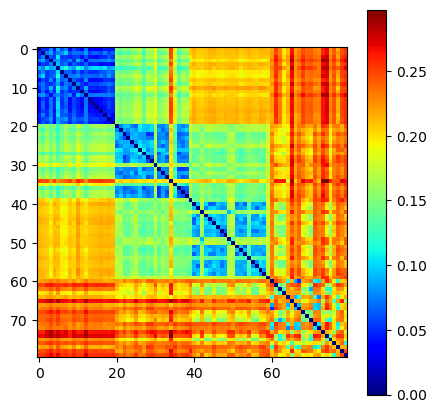

In [67]:
plt.figure(figsize=(5,5))
plt.imshow(lgw0, cmap='jet')
plt.colorbar()
plt.show()

In [68]:
from lib.linear_gromov import LGW_embedding, LGW_dist, LMPGW_embedding, LMPGW_dist, LPGW_embedding, LPGW_dist

In [69]:
Ps = []
for i in range(len(Ms)):
    gamma = gromov_wasserstein(M_ref, Ms[i], height_ref, heights[i], G0=None,thres=1, numItermax=100*N, tol=1e-5,log=False, verbose=False,line_search=False)
    P = LGW_embedding(M_ref, Ms[i], posns[i], height_ref, heights[i], gamma=gamma, loss='square')
    Ps.append(P)

N = 80
st = time.time()        
lgw = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        lgw[i, j] = LGW_dist(Ps[i], Ps[j], height_ref)

# mpgw[mpgw < 0] = 0
lgw = np.sqrt(lgw)
# lgw += lgw.T
et = time.time()
print("LGW computation: " + str(np.round(et-st,2)) + "s")

LGW computation: 0.02s


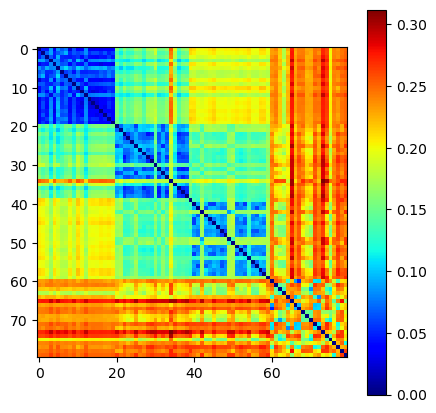

In [70]:
plt.figure(figsize=(5,5))
plt.imshow(lgw, cmap='jet')
plt.colorbar()
plt.show()

In [12]:
print("PCC: " + str(np.round(np.corrcoef(gw.flatten(),lgw.flatten())[1,0],4)))

m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
m_lgw = np.ma.masked_equal(lgw, 0.0, copy=False)

print("MRE: " + str(np.round(np.mean(np.abs(m_gw - m_lgw)/m_gw),4)))

PCC: 0.9612
MRE: 0.0854


# Scale images for paper

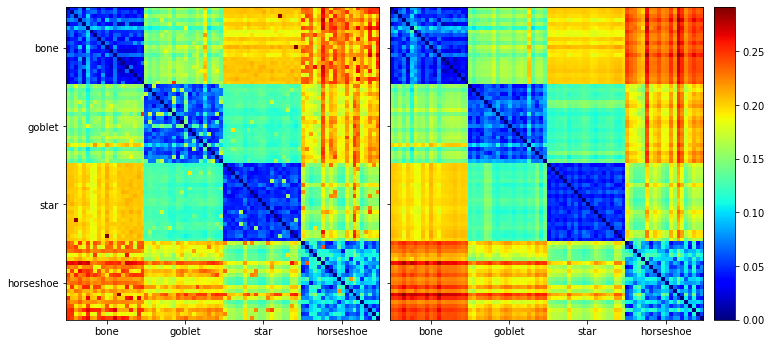

In [13]:
data1 = gw
data2 = lgw

resultant = [data1,data2]

min_val, max_val = np.amin(resultant), np.amax(resultant)


# Set up figure and image grid
fig = plt.figure(figsize=(12, 6))


grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

animal_strings = ["bone","goblet","star","horseshoe"]
x = [10,30,50,70]

plt.setp(grid, xticks=x, xticklabels=animal_strings,
        yticks=x, yticklabels=animal_strings)

# Add data to image grid
i=0
for ax in grid:
    ax.xaxis.get_label().set_fontsize(20)
    ax.yaxis.get_label().set_fontsize(20)
    if i == 0:
        im = ax.imshow(data1, vmin = min_val, vmax = max_val,cmap = "jet")
    elif i == 1:
        im = ax.imshow(data2, vmin = min_val, vmax = max_val,cmap = "jet")
    i+=1

# Colorbar
ax.cax.colorbar(im)
#matplotlib.colorbar.Colorbar(ax.cax,im)
#ax.cax.cla()
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

# Classification

In [14]:
X = np.arange(N)                                           #dataset
y = np.concatenate([np.ones(numItem)*i for i in classes])  #labels

# Confusion matrix

In [15]:
def conf_mat(dists,X,y,n_its = 10000):
    N = len(y)
    classes = np.array(np.unique(y),dtype=int)
    x_pred = []
    x_true = []
    for j in range(n_its):
        l = []
        for i in classes:
            l.append([np.random.choice(X[y == i]),i])
        l = np.array(l)
        for i in range(N):
            tmp1 = np.argmin(dists[i][l[:,0]])
            x_true.append(y[i])
            x_pred.append(tmp1)
    
    conf = sklearn.metrics.confusion_matrix(x_true, x_pred)
    return conf

In [16]:
#compute confusion matrices
conf_gw = conf_mat(gw,X=X,y=y) 
conf_lgw = conf_mat(lgw,X=X,y=y)

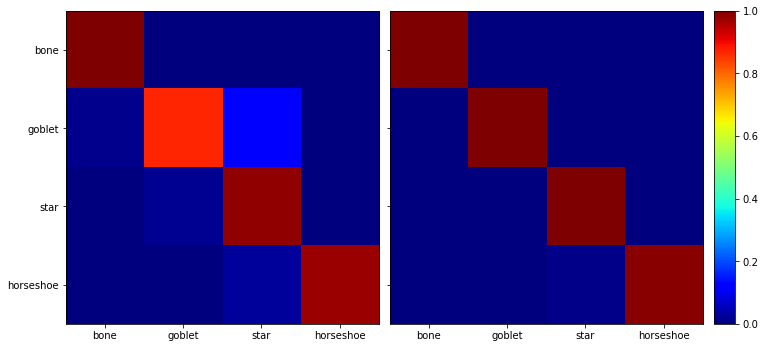

In [17]:
data1 = conf_gw/np.max(conf_gw)
data2 = conf_lgw/np.max(conf_lgw)

#resultant = [data1,data2]

min_val, max_val = 0,1


# Set up figure and image grid
fig = plt.figure(figsize=(12, 6))
grid = ImageGrid(fig, 111,          
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )
animal_strings = ["bone","goblet","star","horseshoe"]
x = [0,1,2,3]
plt.setp(grid, xticks=x, xticklabels=animal_strings,
        yticks=x, yticklabels=animal_strings)

# Add data to image grid
i=0
for ax in grid:
    ax.xaxis.get_label().set_fontsize(20)
    ax.yaxis.get_label().set_fontsize(20)
    if i == 0:
        im = ax.imshow(data1, vmin = min_val, vmax = max_val,cmap = "jet")
    elif i == 1:
        im = ax.imshow(data2, vmin = min_val, vmax = max_val,cmap = "jet")
    i+=1

# Colorbar
ax.cax.colorbar(im)
ax.cax.toggle_label(True)
plt.show()

# Perform 10-fold cross validation

In [18]:
gamma = 10

In [19]:
#K_folds for GW
k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
k_folds.get_n_splits(X,y)

accs_gw = []

for train_index,test_index in k_folds.split(X,y):
    #get train and test data for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    #set up SVM
    kernel_train = np.exp(-gamma*gw[X_train].T[X_train].T)
    svc = svm.SVC(kernel="precomputed")
    
    #fit SVM
    clf = svc.fit(kernel_train, y_train)

    kernel_test = np.exp(-gamma*gw[X_test].T[X_train].T)
    #kernel_test = np.array([[gw_kernel(i,j,gamma=gamma) for i in X_train] for j in X_test])
    acc = clf.score(kernel_test, y_test)
    accs_gw.append(acc)

In [20]:
print("Accuracies: " + str(accs_gw) + ",\nMean accuracy: " + str(np.mean(accs_gw)))

Accuracies: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
Mean accuracy: 1.0


In [22]:
def k_folds_lgw(k_bary):
    #K_folds for LGW
    np.random.seed(0)

    k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
    k_folds.get_n_splits(X,y)
    accs_lgw = []
    corcoeffs = []
    mres = []

    count = 0
    for train_index,test_index in k_folds.split(X,y):
        #get train and test data for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #compute barycenter for train
        idx_bary = [np.random.choice(np.where(y_train == i)[0]) for i in classes]
        count += 1
        n_bary = len(idx_bary)
        #k_bary = 15

        st = time.time()
        M_ref = ot.gromov.gromov_barycenters(k_bary, Cs = np.array(Ms)[idx_bary],
                                                   ps = np.array(heights)[idx_bary], p = ot.unif(k_bary), lambdas = ot.unif(n_bary), loss_fun='square_loss',  # 5e-4,
                                                   max_iter=200, tol=1e-12,random_state=2746)
        et = time.time()
        height_ref = ot.unif(k_bary)
        #print("Computing the barycenter took " + str(et-st) + " seconds.")

        #compute LGW
        lgw,t = lgw_procedure(M_ref,height_ref,posns,Ms,heights,mode="euclidean")
        #print("LGW computation: " + str(np.round(t,2)) + "s")

        #PCC
        corcoeffs.append(np.corrcoef(gw.flatten(),lgw.flatten())[0,1])

        #MRE
        m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
        m_lgw = np.ma.masked_equal(lgw, 0.0, copy=False)
        mres.append(np.mean(np.abs(m_gw - m_lgw)/m_gw))

        #set up SVM
        kernel_train = np.exp(-gamma*lgw[X_train].T[X_train].T)
        svc = svm.SVC(kernel="precomputed")

        #fit SVM
        clf = svc.fit(kernel_train, y_train)

        kernel_test = np.exp(-gamma*lgw[X_test].T[X_train].T)
        acc = clf.score(kernel_test, y_test)
        accs_lgw.append(acc)
    print("        Accuracy   PCC     MRE")
    for i in range(10):
        print("It " + str(i) + ":   " 
              + str(np.round(accs_lgw[i],3)) 
              + "        " 
              + str(np.round(corcoeffs[i],3))
              + "    "
              + str(np.round((mres[i]),3)))

    print("Mean ACC: " + str(np.mean(accs_lgw)))
    print("+-: " + str(np.round(np.std(accs_lgw),4)))
    print("Mean PCC: " + str(np.round(np.mean(corcoeffs),4)))
    print("+-: " + str(np.round(np.std(corcoeffs),4)))
    print("Mean MRE: " + str(np.round(np.mean(mres),4)))
    print("+-: " + str(np.round(np.std(mres),4)))

In [23]:
for k_bary in [15,25,35,45,55]:
    print("No. of points in bary: " + str(k_bary))
    k_folds_lgw(k_bary)

No. of points in bary: 15
        Accuracy   PCC     MRE
It 0:   1.0        0.78    0.253
It 1:   1.0        0.584    0.441
It 2:   0.875        0.835    0.236
It 3:   1.0        0.773    0.238
It 4:   1.0        0.918    0.142
It 5:   0.875        0.938    0.122
It 6:   1.0        0.865    0.201
It 7:   1.0        0.846    0.213
It 8:   1.0        0.935    0.122
It 9:   1.0        0.568    0.482
Mean ACC: 0.975
+-: 0.05
Mean PCC: 0.8042
+-: 0.1265
Mean MRE: 0.2449
+-: 0.1178
No. of points in bary: 25
        Accuracy   PCC     MRE
It 0:   1.0        0.819    0.269
It 1:   1.0        0.772    0.31
It 2:   1.0        0.822    0.334
It 3:   1.0        0.761    0.298
It 4:   1.0        0.71    0.462
It 5:   0.875        0.853    0.197
It 6:   1.0        0.824    0.265
It 7:   0.875        0.848    0.229
It 8:   0.875        0.763    0.303
It 9:   1.0        0.703    0.373
Mean ACC: 0.9625
+-: 0.0573
Mean PCC: 0.7875
+-: 0.0512
Mean MRE: 0.304
+-: 0.0711
No. of points in bary: 35
        A